# Probabilistc Matrix Factorization model with mean-field variational inference - pyTorch implementation.

We train a Probabilistic Matrix Factorization model [1] using mean-field variational inference with automatic differentiation [2] in pyTorch. Our implementation works on dense representation and does not make a use of data sparsity but performs minibatching over data (matrix) rows

1. Mnih, Andriy, and Russ R. Salakhutdinov. "Probabilistic matrix factorization." Advances in neural information processing systems. 2008.
2. Kucukelbir, Alp, et al. "Automatic differentiation variational inference." The Journal of Machine Learning Research 18.1 (2017): 430-474.

## Imports

In [1]:
import numpy as np

import torch
from torch.distributions import Normal
from torch.nn.functional import softplus

import logging
logger = logging.getLogger(__name__)

## Data minibatches

To create minibatches we split data along the first dimension:
each batch consists of subset of rows.
Apart from the data matrix we pass an associated data mask
marking non-empty (and included in the training subset) cells.

In [2]:
class MaskedMatrix(torch.utils.data.Dataset):
    """ Splits masked data along the first (rows) dimension. """
    
    def __init__(self, x, mask):
        self.x = x
        self.mask = mask        

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):        
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        return {"rows": idx, "x": self.x[idx], "mask": self.mask[idx]}     

## Model

Below we provide a complete implementation of mean-field automatic VI for PMF. Read through comments to find about details.

In [3]:
class PMF_MFVI:
    """ Toy implementation of Probabilistc Matrix Factorization 
        training using mean-field automatic VI 
        with minibatching over data rows.
        
        Probabilistc Matrix Factorization model: 
        X ~ N(ZW, sigma), W ~ prior_w(.), Z ~ prior_z(.)
        where Y has shape (N, D), Z has shape (N, K) and W has shape(K, D).    
        K is a latent dimension - size of latent representation.
        By default we use 
        prior_z=Normal(0, 1.), prior_w = Normal(0, 1.) and sigma=1.
        
        We assume approximate (factorized) distributions q:
        qz_ij = Normal(qz_ij_loc, qz_ij_scale)
        qw_ij = Normal(qw_ij_loc, qw_ij_scale)
        Internally we store 4 matrices: 
         - qz_loc, qz_scale - describing approximate posterior of Z
         - qw_loc, qw_scale - describing approximate posterior of W        
    """
    
    def __init__(self, N=1, K=1, D=1,  
                 optimizer_class=torch.optim.Adam, lr=0.005,
                 prior_z=Normal(0, 1.), prior_w = Normal(0, 1.), 
                 likelihood_class=lambda xhat: Normal(xhat, 1.)):        
        self.prior_z = prior_z
        self.prior_w = prior_w
        self.likelihood_class = likelihood_class
        
        self.optimizer_class = optimizer_class
        self.lr = lr
        
        self.N = N
        self.K = K
        self.D = D        
        self.restart()

    def restart(self):
        """ Random initialization of approximate posteriors. """
        N, K, D = self.N, self.K, self.D # just for brevity
        
        self.qz_loc = torch.randn([N, K], requires_grad=True)
        self.qz_scale = torch.randn([N, K], requires_grad=True)
        self.qw_loc = torch.randn([K, D], requires_grad=True)
        self.qw_scale = torch.randn([K, D], requires_grad=True)          
        
        trained_params = [self.qw_loc, self.qw_scale, self.qz_loc, self.qz_scale]
        self.optimizer = self.optimizer_class(trained_params, lr=self.lr)
        self._iteration = 0
    
    def sample_prior(self, nsamples_latent=1, nsamples_x=1):
        """ Returns a sample (w, z, x) from prior distribution.
        
            Args:
                nsamples_latent (int): How many samples of Z and W.
                nsamples_x (int): How many samples of X for each latent sample.
        """        
        # sample (r stands for reparametrized) latent
        z = self.prior_w.rsample([nsamples_latent, self.N, self.K])
        w = self.prior_z.rsample([nsamples_latent, self.K, self.D])
        xhat = z.matmul(w)
        
        # sample (r stands for reparametrized) observed
        lik = self.likelihood_class(xhat)
        x = lik.rsample([nsamples_x])
       
        if nsamples_latent==1 and nsamples_x==1:
            w, z, x = w[0], z[0], x[0,0]        
        return w, z, x  

    @property
    def qw(self):
        """ Retrieves approximating distribution of latent variable W. """
        return Normal(self.qw_loc, softplus(self.qw_scale))
    
    @property
    def qz(self):
        """ Retrieves approximating distribution of latent variable Z. """
        return Normal(self.qz_loc, softplus(self.qz_scale))            
    
    def sample(self, nsamples_latent=1, nsamples_x=1):  
        """ Returns a tensor with samples from approximate predictive distribution.  
            Samples are reparametrized, e.g., are differentiable w.r.t 
            approximate distribution parameters qz_loc, qz_scale, qw_loc and qw_scale.
            
            Args:
                nsamples_latent (int): How many samples of Z and W.
                nsamples_x (int): How many samples of X for each latent sample.
        """
        # sample (r stands for reparametrized) latent
        w = self.qw.rsample([nsamples_latent])
        z = self.qz.rsample([nsamples_latent])
        xhat = z.matmul(w)
        
        # sample (r stands for reparametrized) observed        
        lik = self.likelihood_class(xhat)
        x = lik.rsample([nsamples_x])

        if nsamples_latent==1 and nsamples_x==1:
            w, z, x = w[0], z[0], x[0,0]        
        return x
            
    def model_log_prob(self, x, w, z, mask=None):
        """ Joint log-probability of data x and parameters (w, z).
        
            Returns:
                log(likelihood(x|w,z) * prior_w(w) * prior_z(z))                

            Args:
                mask (tensor): Boolean mask of shape like x, 
                               selecting non-empty cells.
                               Default: None (use all data).
        """
        if mask is None: 
            mask = torch.ones_like(x).type(torch.bool).to(x.device)
        # since we are using mininbatches, the proprtion between data likelihood and 
        # priors need to be weighted accordingly (=like we used a whole data)        
        minibatch_scaling = self.N/x.shape[0]  
        
        xhat = z.matmul(w)
        likelihood = self.likelihood_class(xhat)
        assert likelihood.loc.shape[1: ] == x.shape

        # note rescaling of data likelihood and qz (the factor depending on number of rows)
        return torch.masked_select(likelihood.log_prob(x), mask).sum()*minibatch_scaling \
                + self.prior_w.log_prob(w).sum() \
                + self.prior_z.log_prob(z).sum()*minibatch_scaling
    
    def elbo(self, x_minibatch, mask_minibatch, qw, qz,
             latent_variables_nsamples=16): 
        """ Returns a MC estimate of ELBO 
            for given minibatch and approximations qw and qz. """
        
        # reparametrized sampling from the approximation
        w = qw.rsample([latent_variables_nsamples]) 
        z = qz.rsample([latent_variables_nsamples])

        minibatch_scaling = self.N/x_minibatch.shape[0]                     
        # MC estimate of the entropy term
        entropy = -qw.log_prob(w).sum() -qz.log_prob(z).sum()*minibatch_scaling 
        # data and parameters joint log-probability
        log_prob = self.model_log_prob(x_minibatch, w, z, mask_minibatch).sum()
        # MC estimate of elbo
        elbo = log_prob + entropy
        elbo = elbo/latent_variables_nsamples
        
        return elbo   
    
    def fit(self, loader, nepochs=1, latent_variables_nsamples=16):
        """ Runs requested number of epochs of data fitting. """
        
        # check if dimensions match
        if len(loader.dataset)!=self.N:
            logger.warning("Reinitializing fit due to data length change!")
            self.N = len(loader.dataset)
            self.restart()
                    
        for e in range(nepochs):
          for minibatch in loader:  
            
            # check if dimensions match
            assert minibatch["x"].shape == minibatch["mask"].shape                                    
            if minibatch["x"].shape[1]!=self.D:
                logger.warning("Reinitializing fit due to data dimensionality change!")
                self.D = minibatch["x"].shape[1]
                self.restart()
                
            self._iteration += 1
            self.optimizer.zero_grad()                                        

            # obtain the current approximation
            # (using current values of qz_loc, qz_scale, ...)
            qw = Normal(self.qw_loc, softplus(self.qw_scale))
            minibatch_rows = minibatch["rows"]
            qz = Normal(self.qz_loc[minibatch_rows, :], 
                        softplus(self.qz_scale[minibatch_rows, :] ))
            
            # use -ELBO as a loss
            loss = -self.elbo(minibatch["x"], minibatch["mask"], 
                              qw, qz, latent_variables_nsamples)
                        
            # optimization step
            logger.debug("%i. iteration: loss=%.3f" % (self._iteration, loss))              
            loss.backward(retain_graph=False)
            self.optimizer.step() # update approximation parameters qz_loc, qz_scale, ...
            
          logger.info("%i. epoch / %i. iteration: loss=%.3f" % \
                    (e+1, self._iteration, loss))                


### Data generation

Data is generated by sampling from prior distribution.
Then, with probability nonmissing_p we choose 'non-empty' cells.
Finally, the non-empty cells, according to probability training_p,
we randomly split into training and test subset.

In [4]:
def generate_data(m=PMF_MFVI(123, 4, 11), 
                  nonmissing_p=0.05, training_p=0.5):
    """ Samples artificial data from the model. """
    w_true, z_true, x = m.sample_prior()

    # sample non-empty values, training & test mask
    mask = np.random.choice([True, False], (m.N, m.D), 
                            p=[nonmissing_p, 1.-nonmissing_p])    
    training_mask = np.random.choice([True, False], (m.N, m.D), 
                            p=[training_p, 1.-training_p])   
    test_mask = ~training_mask & mask
    training_mask = training_mask & mask
    
    test_mask = torch.tensor(test_mask) 
    training_mask = torch.tensor(training_mask)
    
    return w_true, z_true, x, training_mask, test_mask

### Training

In [5]:
    np.random.seed(125)
    torch.manual_seed(125)
    logging.basicConfig(level=logging.INFO, format='%(relativeCreated)6d %(message)s')

Prepare data

In [6]:
    w_true, z_true, x, training_mask, test_mask = generate_data()
    dataset = MaskedMatrix(x, training_mask)
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

Train and evaluate

 Note that for generated data latent dimension was K=4 whereas here we use K=2.

In [7]:
    m = PMF_MFVI(K=2) # mismatched model
    test_rmses = []
    for e in range(100):
        m.fit(loader)
        
        # evaluate on the test subset
        predictions = m.sample(100).mean([0,1]) # empirical expectations
        test_rmse = torch.masked_select((predictions-x)**2, test_mask).mean().sqrt()
        test_rmses.append(test_rmse)

   904 Reinitializing fit due to data length change!
   906 Reinitializing fit due to data dimensionality change!
   951 1. epoch / 8. iteration: loss=624.236
  1014 1. epoch / 16. iteration: loss=761.019
  1056 1. epoch / 24. iteration: loss=190.928
  1104 1. epoch / 32. iteration: loss=588.584
  1143 1. epoch / 40. iteration: loss=875.210
  1175 1. epoch / 48. iteration: loss=185.768
  1223 1. epoch / 56. iteration: loss=471.640
  1264 1. epoch / 64. iteration: loss=215.421
  1293 1. epoch / 72. iteration: loss=174.616
  1323 1. epoch / 80. iteration: loss=269.268
  1359 1. epoch / 88. iteration: loss=478.387
  1395 1. epoch / 96. iteration: loss=832.257
  1432 1. epoch / 104. iteration: loss=419.271
  1466 1. epoch / 112. iteration: loss=294.042
  1504 1. epoch / 120. iteration: loss=479.445
  1548 1. epoch / 128. iteration: loss=280.792
  1587 1. epoch / 136. iteration: loss=547.537
  1631 1. epoch / 144. iteration: loss=365.749
  1659 1. epoch / 152. iteration: loss=203.954
  1701

Plot test RMSE vs epoch

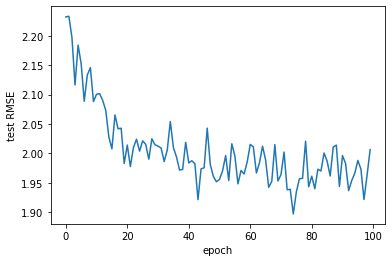

In [9]:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(test_rmses)
    plt.xlabel("epoch")
    plt.ylabel("test RMSE")
    plt.show()    